# Plot surface

Plotting just some basic 3D surface for showcasing it in the paper.

In [23]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

import seaborn as sns

from typing import Callable
import jax 
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Times New Roman"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

dpi_value = 300

## Struggle with getting a good colormap

In [24]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap

# def fill_area_with_gradient(x, y, colormap='viridis', alpha=0.5):
#     """
#     Fill the area under a curve with a vertical color gradient using a specified colormap.

#     Parameters:
#         x (array-like): X-coordinates of the curve.
#         y (array-like): Y-coordinates of the curve.
#         colormap (str or LinearSegmentedColormap, optional): Colormap to use for the gradient. Default is 'viridis'.
#         alpha (float, optional): Alpha value for the transparency of the gradient. Default is 0.5.

#     Returns:
#         None
#     """
#     # Create a linear gradient colormap
#     if isinstance(colormap, str):
#         colormap = plt.get_cmap(colormap)
#     elif not isinstance(colormap, LinearSegmentedColormap):
#         raise ValueError("colormap should be a string or a LinearSegmentedColormap object")

#     # Plot the curve
#     plt.plot(x, y, color='black')

#     # Calculate colors based on the y-values of the curve
#     normalized_y = (y - min(y)) / (max(y) - min(y))  # Normalize y-values between 0 and 1

#     # Create a meshgrid of colors along the y-axis
#     colors = colormap(normalized_y[:, np.newaxis])

#     # Fill the area under the curve with the gradient
#     plt.fill_between(x, y, color='none', facecolor=colors, alpha=alpha)

# # Example usage:
# x = np.linspace(0, 10, 100)
# y = np.sin(x)
# fill_area_with_gradient(x, y, colormap='viridis', alpha=0.5)


Just going to choose a different colormap for the surface plot.

In [25]:

# # Define a custom colormap with a white background
# # You can use LinearSegmentedColormap to define custom colormaps
# from matplotlib.colors import LinearSegmentedColormap
# # # Create a modified viridis colormap
# # viridis_white = plt.cm.viridis(np.linspace(0, 1, 256))
# # white = (1, 1, 1, 1)
# # viridis_white[0] = white  # Set the lowest value color to white

# # # Create a LinearSegmentedColormap using the modified viridis colormap
# # my_cmap = LinearSegmentedColormap.from_list('viridis_white', viridis_white)

# # Define the threshold for when transparency starts to kick in
# threshold = 0.05  # Adjust this threshold as needed

# # Create a custom colormap for values below the threshold
# def custom_cmap():
#     colors = [(1, 1, 1, 1)]  # Start with white for lowest values
#     for i in range(1, 256):
#         alpha = min(1.0, max(0.0, (i - 1) / 256 / threshold))  # Adjust transparency based on threshold
#         colors.append((0.267004, 0.004874, 0.329415, alpha))  # Adjust this color as needed
#     return LinearSegmentedColormap.from_list('custom_cmap', colors)

# # Combine the custom colormap with the regular Viridis colormap for higher values
# viridis_white = plt.cm.viridis(np.linspace(0, 1, 256))
# viridis_white[0] = (1, 1, 1, 1)  # Set the lowest value color to white
# viridis_custom = LinearSegmentedColormap.from_list('viridis_custom', viridis_white)

# # Create a combined colormap
# def combined_cmap():
#     return LinearSegmentedColormap.from_list('combined_cmap', [viridis_custom(i) for i in np.linspace(0, 1, 128)] + [(0.267004, 0.004874, 0.329415, 1)] * 128)

# my_cmap = combined_cmap()

Have a look at the color palettes: https://seaborn.pydata.org/tutorial/color_palettes.html

## Prepare for the plot

In [26]:
cmap = plt.cm.jet  
# my_cmap = mpl.colormaps['rocket_r'] # 'rocket'

# my_cmap = sns.cubehelix_palette(as_cmap=True)
# my_cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
my_cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
# my_cmap_nf = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True)
# my_cmap_nf = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
my_cmap_nf = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
# my_cmap_nf = mpl.colormaps['rocket_r'] # 'rocket'
# my_cmap_nf = sns.dark_palette("#69d", reverse=True, as_cmap=True)
# my_cmap_nf = sns.color_palette("light:b", as_cmap=True)
# my_cmap_nf = sns.color_palette("Blues", as_cmap=True)
# my_cmap_nf = sns.dark_palette("#69d", reverse=True, as_cmap=True)

# walker_color = "#Ff9400"
walker_color = "red"

Source code adapted from: https://stackoverflow.com/questions/28342968/how-to-plot-a-2d-gaussian-with-different-sigma

In [27]:
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""
    n = mu.shape[0]
    Sigma_det = jnp.linalg.det(Sigma)
    Sigma_inv = jnp.linalg.inv(Sigma)
    N = jnp.sqrt((2*np.pi)**n * Sigma_det)
    fac = jnp.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return jnp.exp(-fac / 2) / N

def mixture_of_gaussians(pos, mus, Sigmas, weights):
    """Return the mixture of multivariate Gaussian distributions on array pos."""
    Z = jnp.zeros_like(pos[:, :, 0])
    for mu, Sigma, weight in zip(mus, Sigmas, weights):
        Z += weight * multivariate_gaussian(pos, mu, Sigma)
    return Z

### Single number versions
def multivariate_gaussian_single_number(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""
    n = mu.shape[0]
    Sigma_det = jnp.linalg.det(Sigma)
    Sigma_inv = jnp.linalg.inv(Sigma)
    N = jnp.sqrt((2*np.pi)**n * Sigma_det)
    fac = jnp.matmul((pos - mu).T, jnp.matmul(Sigma_inv, (pos - mu)))
    return jnp.exp(-fac / 2) / N

def mixture_of_gaussians_single_number(pos, mus, Sigmas, weights):
    """Return the mixture of multivariate Gaussian distributions on array pos."""
    Z = 0
    for mu, Sigma, weight in zip(mus, Sigmas, weights):
        Z += weight * multivariate_gaussian_single_number(pos, mu, Sigma)
    return Z

In [28]:
def gaussian_pert(pos: jnp.array,
                  eps: float = 1e-3) -> jnp.array:
    number_x = np.random.normal()
    number_y = np.random.normal()
    pos += eps ** 2 / 2 * jnp.array([number_x, number_y])
    return pos

def get_trajectory_walker(initial_pos: jnp.array,
                          gradient_fn: Callable,
                          nb_steps: int = 10,
                          eps: float = 0.001,
                          gaussian_eps: float = 0.1): 
    pos = initial_pos 
    trajectory = pos
    for i in range(nb_steps):
        nabla = gradient_fn(pos)
        pos += eps * nabla
        pos = gaussian_pert(pos, gaussian_eps) # like MALA
        trajectory = jnp.vstack((trajectory, pos))
        
    return trajectory

Densities:

In [29]:
# Our 2-dimensional distribution will be over variables X and Y
N = 300
reach = 7
X = np.linspace(-reach, reach, N)
Y = np.linspace(-reach, reach, N)
X, Y = np.meshgrid(X, Y, indexing='xy')

# Mean vectors and covariance matrices for each Gaussian component
mus = [
       jnp.array([-1.0, -2.0]), 
       
       jnp.array([3.0, 2.0])
]

Sigmas = [
       jnp.array([[3.1, 0.25], 
                  [0.25,  1.1]]), 
       
       jnp.array([[2.1, -0.5], 
                  [-0.5,  4.1]])
]

# Some random perturbation, for the so-called NF in this example
mus_nf = [mus[0] + jnp.array([-1.25, 0.25]), 
          mus[1] + jnp.array([-1.5, 0.75])]

cross_value = 0.05
Sigmas_nf = [Sigmas[0] + jnp.array([[0.6, cross_value], [cross_value, -0.5]]), 
             Sigmas[1] + jnp.array([[0.75, cross_value], [cross_value, -0.75]])]

weights = [0.5, 0.5]

# Meshgrid for the plot
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
s = 7
lw = 2.5

elevation_shift = 0.0

# Plot the mixture of Gaussians
Z = mixture_of_gaussians(pos, mus, Sigmas, weights)
Z_nf = mixture_of_gaussians(pos, mus_nf, Sigmas_nf, weights)

Walkers:

In [30]:
np.random.seed(0)
# Compute the jacobian
get_walker_Z = lambda x: mixture_of_gaussians_single_number(x, mus, Sigmas, weights)
get_walker_Z_nf = lambda x: mixture_of_gaussians_single_number(x, mus_nf, Sigmas_nf, weights)
gradient_fn = jax.grad(get_walker_Z)

### Gradient at the walkers

# SINGLE WALKER
walker_initial_pos = jnp.array([-4.25, -2.0])
trajectory = get_trajectory_walker(walker_initial_pos, 
                                   gradient_fn, 
                                   nb_steps = 100, 
                                   eps = 1,
                                   gaussian_eps = 1)

walker_Z = jax.vmap(get_walker_Z)(trajectory)
walker_Z_initial_pos = walker_Z[0]

# initial_pos_list = np.random.uniform(-2.5, 2.5, (n_walkers - 1, 2))
initial_pos_list = [2, 5]
walkers_pos_list = np.vstack(([walker_initial_pos], initial_pos_list))
walkers_pos_list = jnp.array(walkers_pos_list)

# MULTIPLE WALKER
trajectory_list = []

for pos in walkers_pos_list:
    trajectory = get_trajectory_walker(pos, 
                                       gradient_fn, 
                                       nb_steps = 500, 
                                       eps = 1,
                                       gaussian_eps = 0.25)
    trajectory_list.append(trajectory)

# walker_Z_list = jax.vmap(jax.vmap(get_walker_Z))(trajectory_list)
# walker_Z_list_initial_pos = walker_Z_list[0]

# Plot the 2D projection

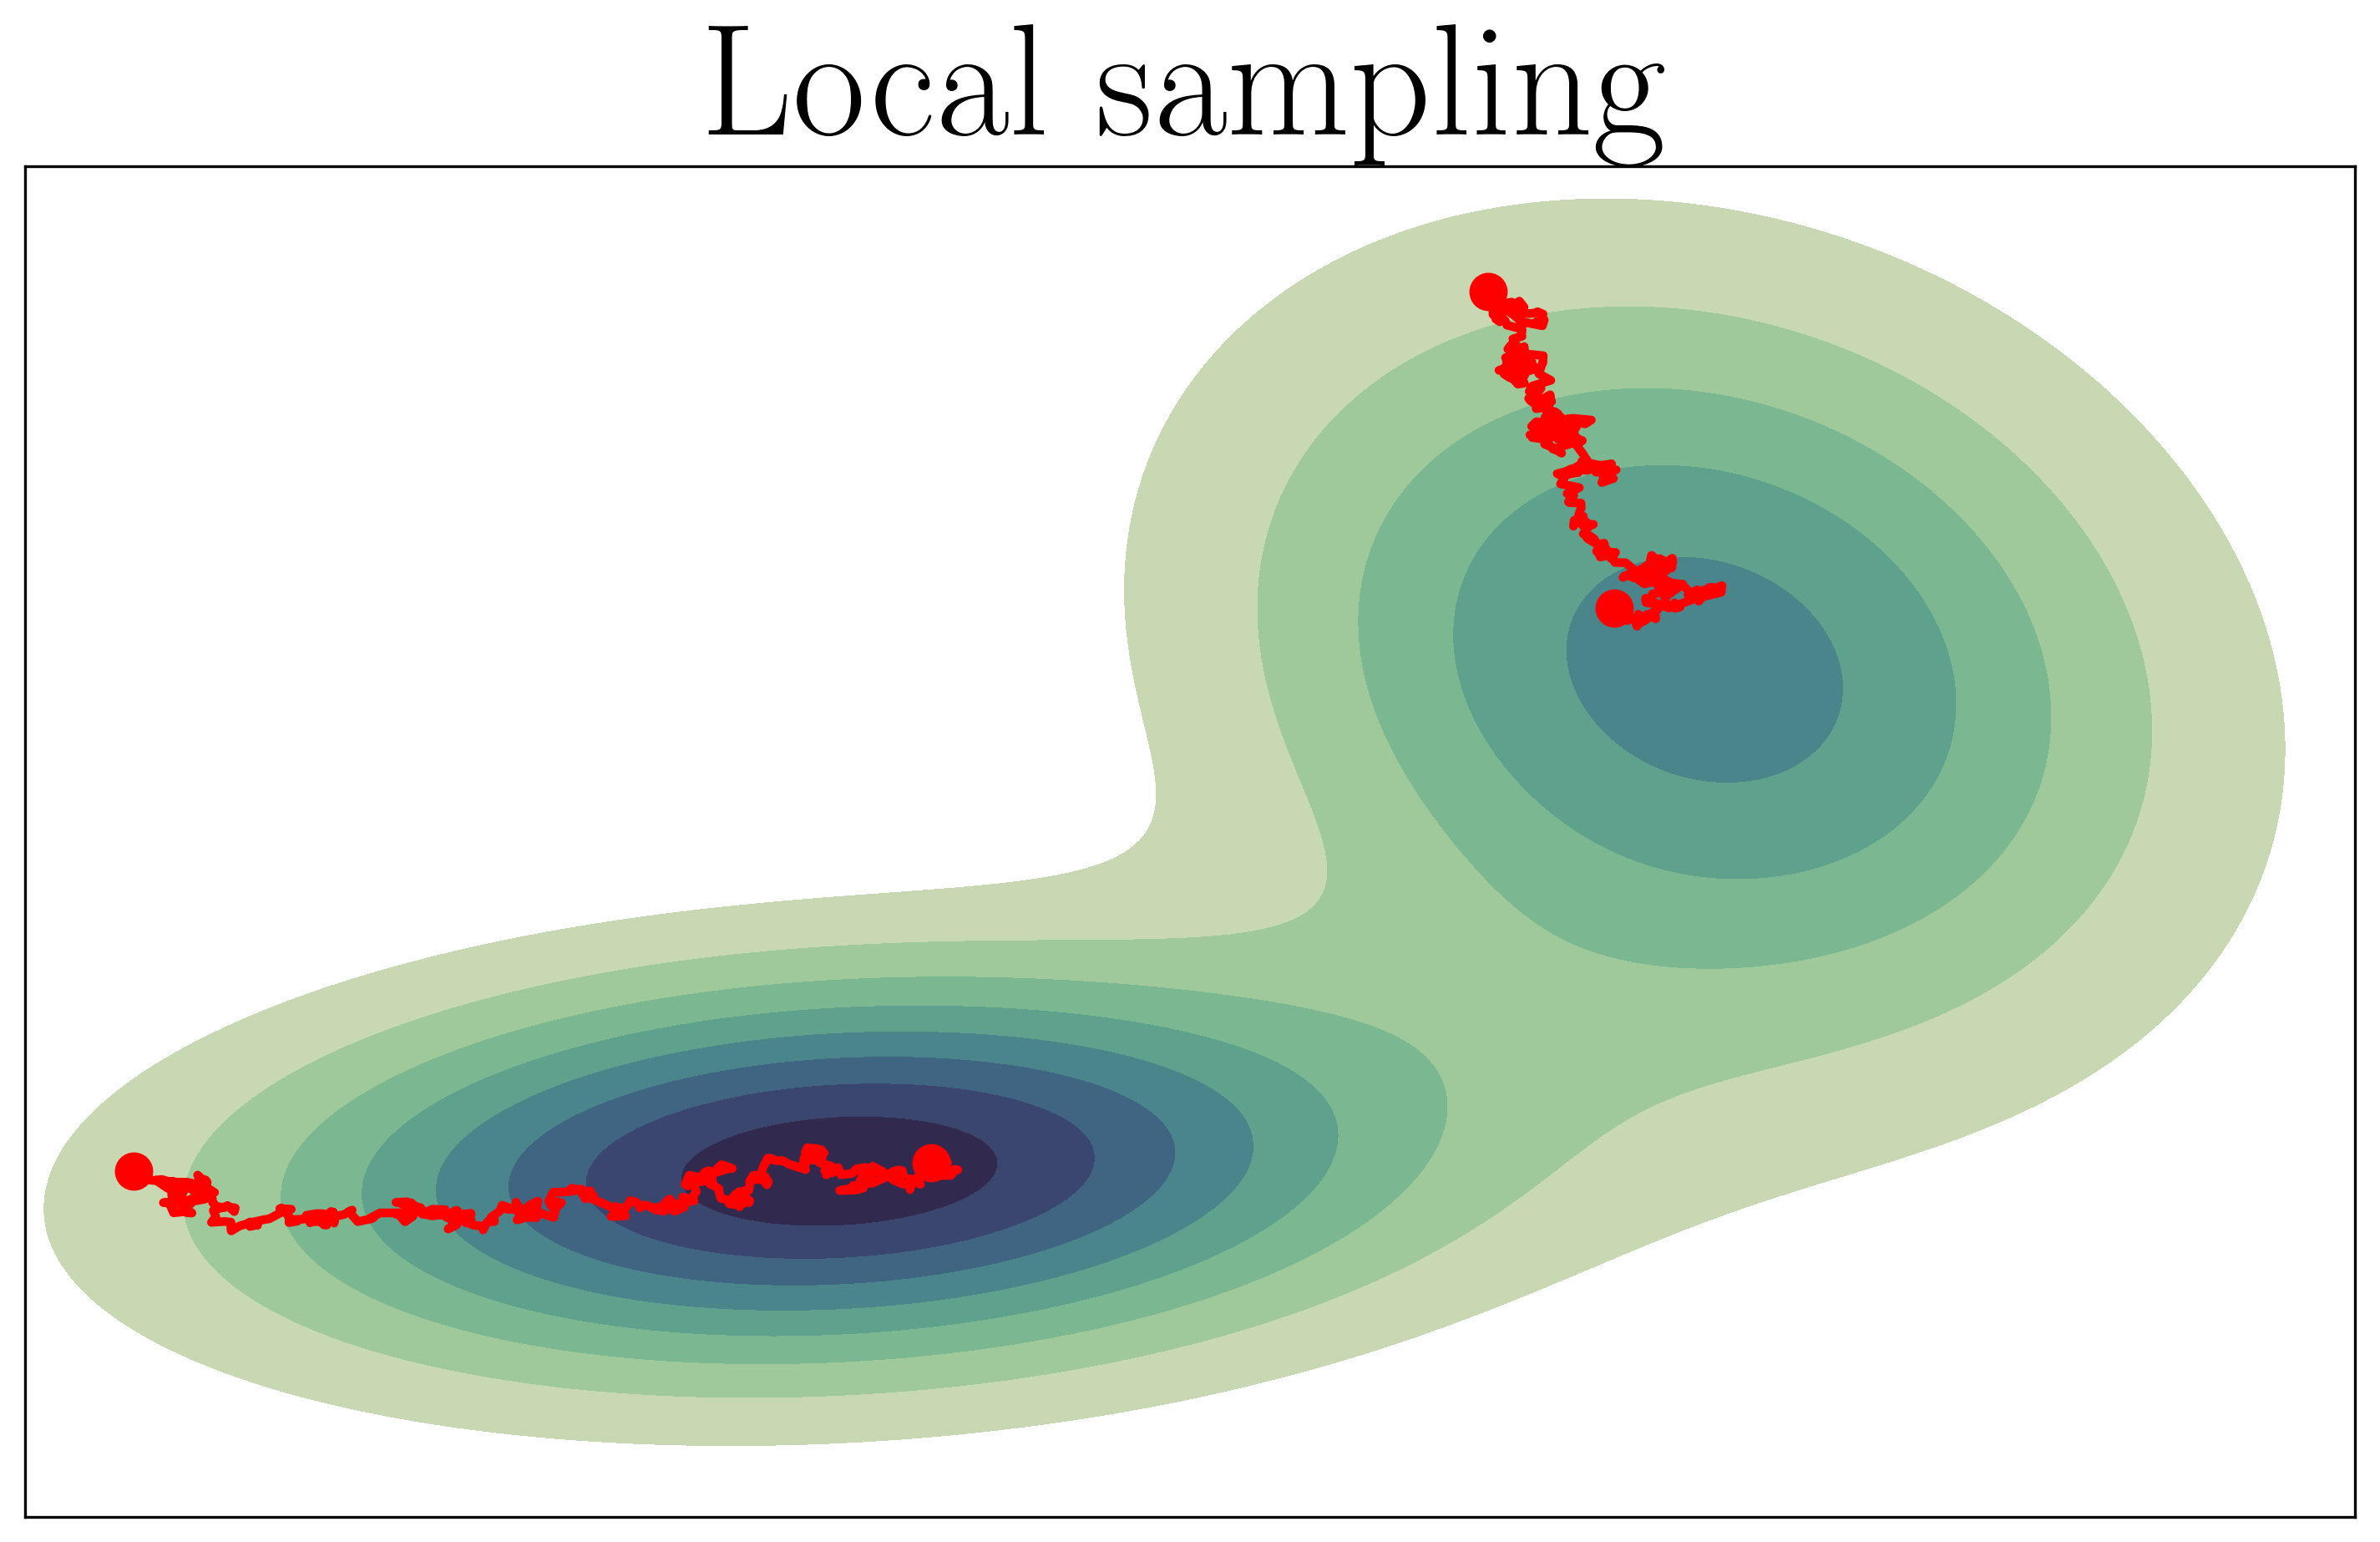

In [31]:
s_2D = 100
lw_2D = 2.5
fig = plt.figure(figsize=(12, 7))
ax2 = fig.add_subplot(111)
ax2.contourf(X, Y, Z, cmap=my_cmap, locator = ticker.MaxNLocator(prune = 'lower'))

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlim(-4.75, 6)
ax2.set_ylim(-4.75, 6)

ax2.plot(Y)
zorder = 1e9
# Trajectories:
for trajectory in trajectory_list:
    ax2.plot(trajectory[:, 0], trajectory[:, 1], linewidth = lw_2D, color = walker_color, alpha = 1, zorder = zorder)
    ax2.scatter(trajectory[0, 0], trajectory[0, 1], color = walker_color, s=s_2D, marker = "o", zorder = zorder)

    # Draw arrow
    first_point = trajectory[int(0.4 * len(trajectory))]
    last_point = trajectory[int(0.5 * len(trajectory))]

    # ax2.arrow(first_point[0], first_point[1], last_point[0] - first_point[0], last_point[1] - first_point[1],
    #             head_width=0.3, head_length=0.3, fc='red', ec='red', zorder = 1e10)
    
    endpoint = trajectory[-1]
    ax2.scatter(endpoint[0], endpoint[1], color = walker_color, s=s_2D, marker = "o", zorder = zorder)

title_fontsize = 46
ax2.set_title("Local sampling", fontsize = title_fontsize)

plt.gcf().set_facecolor('none')

# Adjust DPI
plt.gcf().set_dpi(dpi_value)

# Save the plot as SVG
plt.savefig('mixture_of_gaussians_projection.png', transparent=True, bbox_inches='tight')
plt.savefig('mixture_of_gaussians_projection.svg', transparent=True, bbox_inches='tight', format='svg')
plt.show()

## Figure for extreme matter call

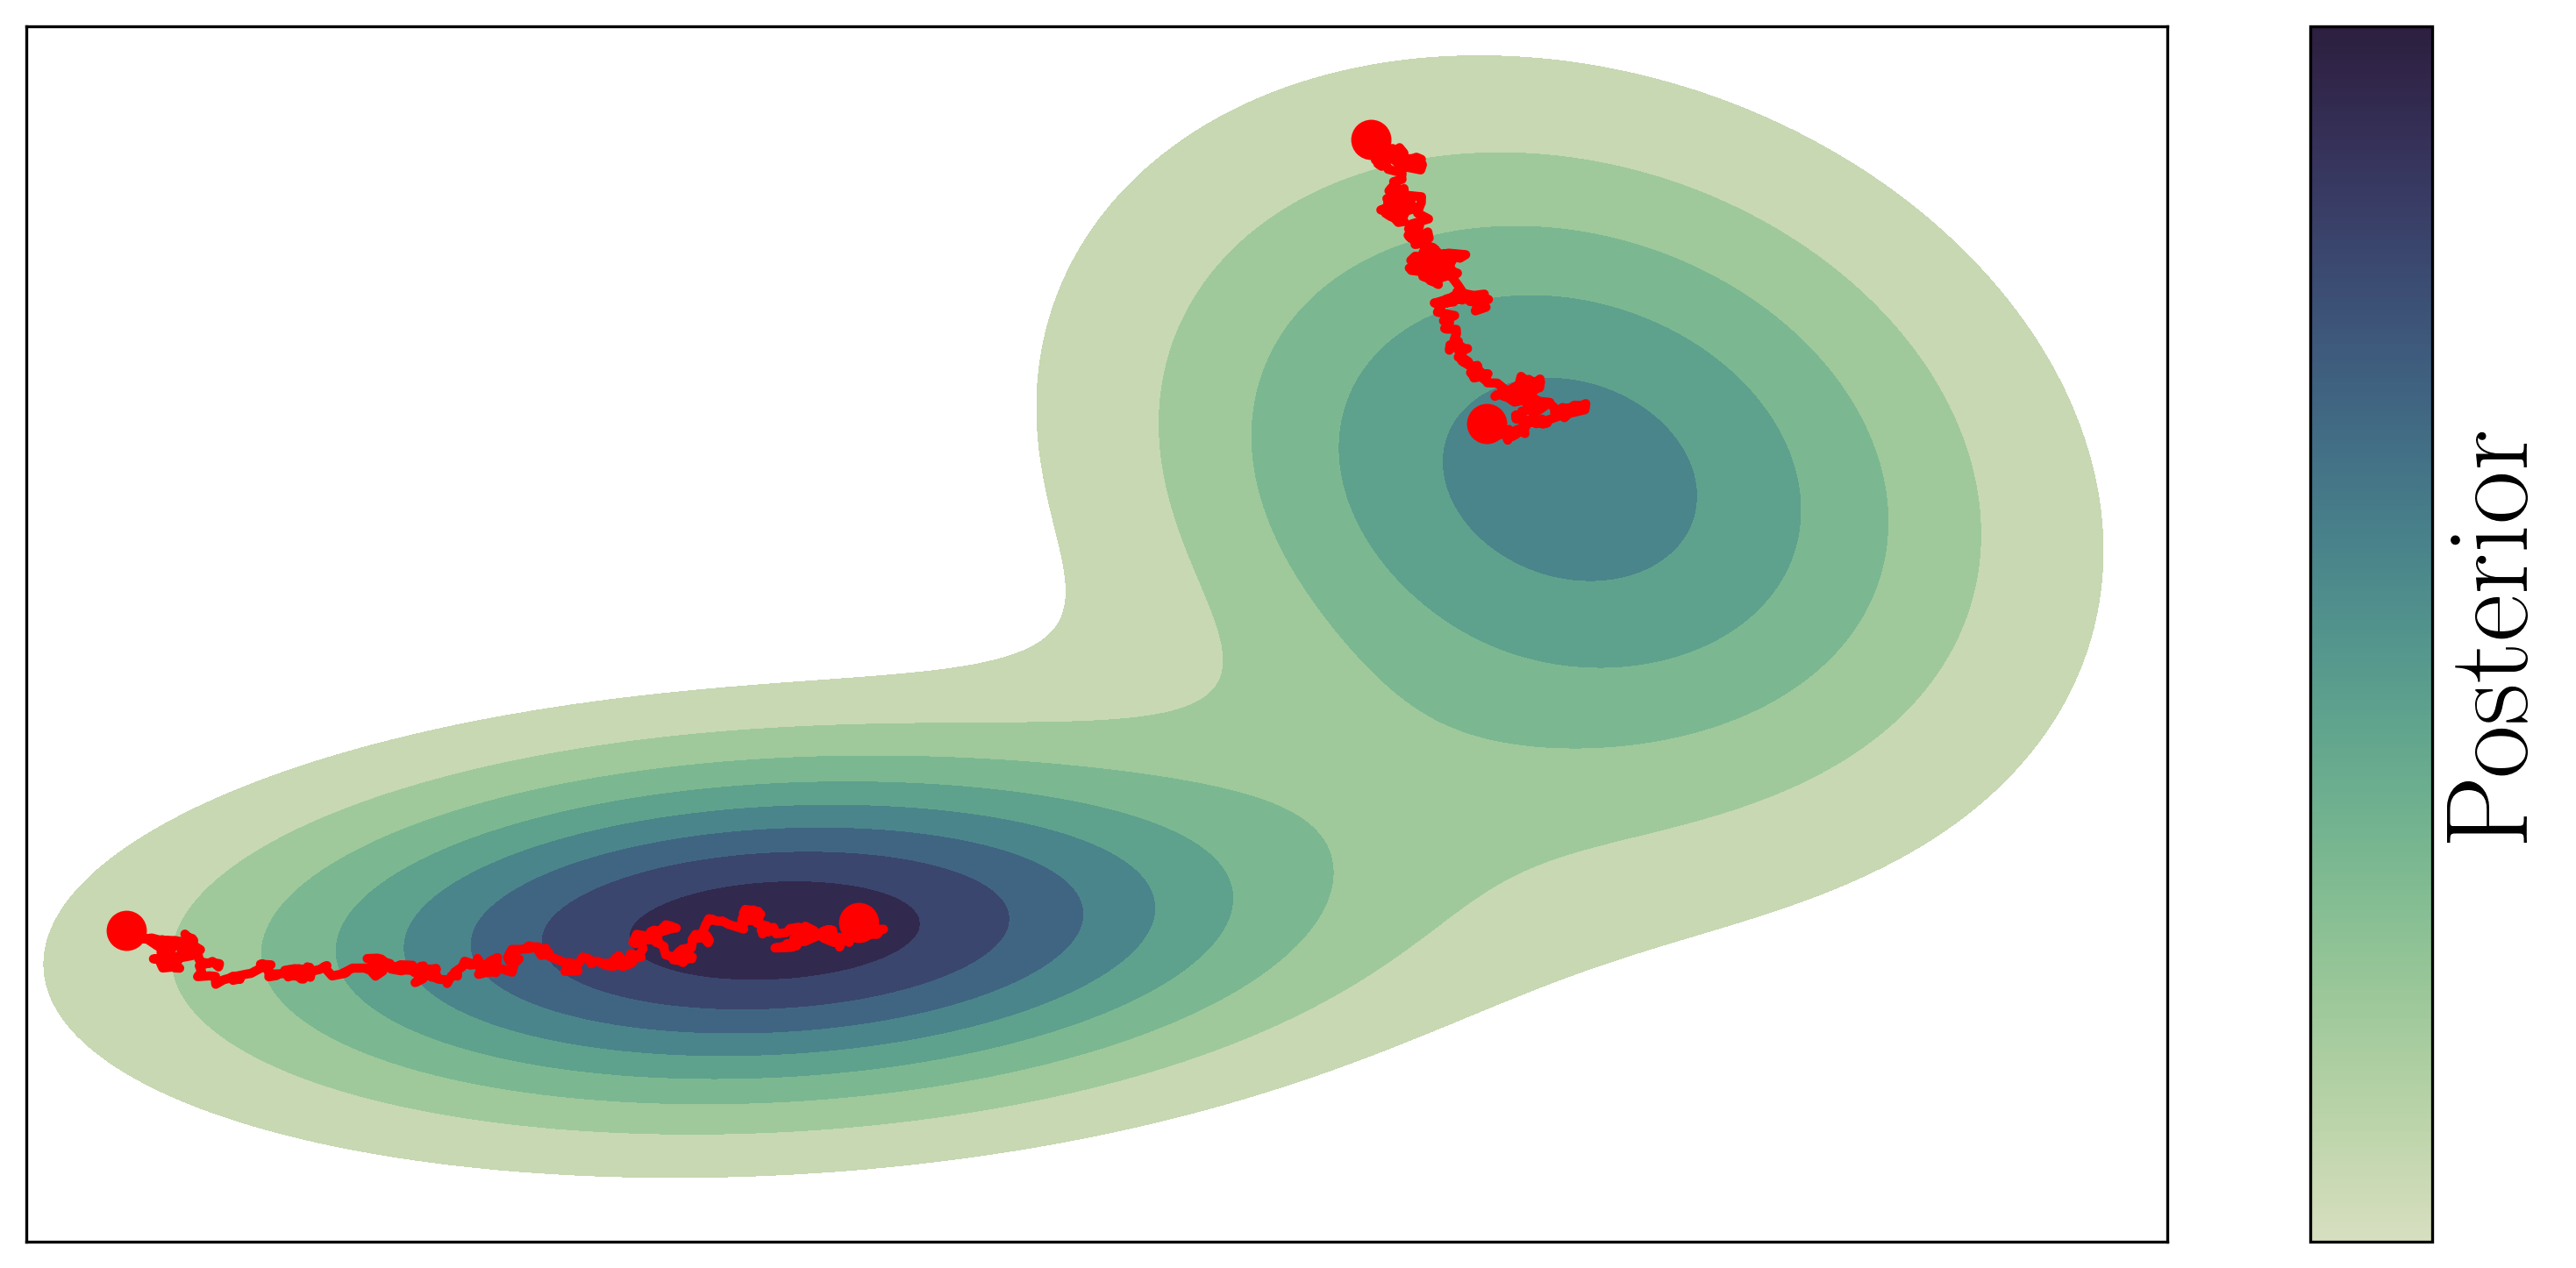

In [32]:
s_2D = 100
lw_2D = 2.5
fig = plt.figure(figsize=(14, 6))
ax2 = fig.add_subplot(111)
ax2.contourf(X, Y, Z, cmap=my_cmap, locator = ticker.MaxNLocator(prune = 'lower'))

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlim(-4.75, 6)
ax2.set_ylim(-4.75, 6)

ax2.plot(Y)
zorder = 1e9
# Trajectories:
for trajectory in trajectory_list:
    ax2.plot(trajectory[:, 0], trajectory[:, 1], linewidth = lw_2D, color = walker_color, alpha = 1, zorder = zorder)
    ax2.scatter(trajectory[0, 0], trajectory[0, 1], color = walker_color, s=s_2D, marker = "o", zorder = zorder)

    # Draw arrow
    first_point = trajectory[int(0.4 * len(trajectory))]
    last_point = trajectory[int(0.5 * len(trajectory))]

    # ax2.arrow(first_point[0], first_point[1], last_point[0] - first_point[0], last_point[1] - first_point[1],
    #             head_width=0.3, head_length=0.3, fc='red', ec='red', zorder = 1e10)
    
    endpoint = trajectory[-1]
    ax2.scatter(endpoint[0], endpoint[1], color = walker_color, s=s_2D, marker = "o", zorder = zorder)

title_fontsize = 46
ax2.set_title("Local sampling", fontsize = title_fontsize)

plt.gcf().set_facecolor('none')

# Adjust DPI
plt.gcf().set_dpi(dpi_value)

# Save the plot as SVG
plt.savefig('mixture_of_gaussians_projection.svg', transparent=True, bbox_inches='tight', format='svg')
plt.title("")
plt.savefig('mixture_of_gaussians_projection_no_title.svg', transparent=True, bbox_inches='tight', format='svg')
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, orientation='vertical', fraction=0.2, aspect=10)

cbar.ax.set_yticks([])

plt.gcf().set_facecolor('none')
plt.gcf().set_dpi(dpi_value)

# Add label to the colorbar

label_fontsize = 32
cbar.set_label("Posterior")

# Position the label
cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.label.set_size(label_fontsize)
plt.savefig('mixture_of_gaussians_projection_no_title_colorbar.svg', transparent=True, bbox_inches='tight', format='svg')
plt.savefig('mixture_of_gaussians_projection_no_title_colorbar.pdf', transparent=True, bbox_inches='tight')
plt.savefig('mixture_of_gaussians_projection_no_title_colorbar.png', transparent=True, bbox_inches='tight')
plt.show()

## 1D projection

In [33]:
def gaussian_1D(x, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""
    N = jnp.sqrt((2*np.pi) * Sigma)
    Sigma_inv = 1 / Sigma
    fac = (x - mu) * Sigma_inv * (x - mu)
    return jnp.exp(-fac / 2) / N

def mixture_of_gaussians_1D(pos, mus, Sigmas, weights):
    """Return the mixture of multivariate Gaussian distributions on array pos."""
    Z = 0
    for mu, Sigma, weight in zip(mus, Sigmas, weights):
        Z += weight * gaussian_1D(pos, mu, Sigma)
    return Z

In [34]:
# lw = 4


# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(36, 7))
# # Meshgrid for the plot
# left_x = -5
# right_x = 6
# X_1D = np.linspace(left_x, right_x, 1_000)

# # Example for the 1D case
# mus_1D = [
#        1.0
# ]
# Sigmas_1D = [
#        1.0
# ]
# weights_1D = [1]
# Z_1D = mixture_of_gaussians_1D(X_1D, mus_1D, Sigmas_1D, weights_1D)
# max_y = np.max(Z_1D)
# ax0.plot(X_1D, Z_1D, color = "gray", linewidth = lw)
# ax0.fill_between(X_1D, Z_1D, color="gray", alpha=0.5)

# # ax1 = fig.add_subplot(111)

# # Example for the 1D case
# mus_1D = [
#        3.0,
#        -1.0
# ]
# Sigmas_1D = [
#        0.7,
#        1.1,
# ]
# weights_1D = [0.5, 0.5]
# Z_1D = mixture_of_gaussians_1D(X_1D, mus_1D, Sigmas_1D, weights_1D)
# # Create arrows for x and y axes
# head_length_fraction = 0.025
# arrow_linewidth = 3
# arrow_zorder = 3
# arrow_length = 1.5 * (right_x - left_x)
# ax0.arrow(left_x, 0, right_x - left_x, 0, head_width=0.005, linewidth = arrow_linewidth, head_length=head_length_fraction * arrow_length, fc='k', ec='k')
# arrow_length = max_y
# ax0.arrow(left_x, 0, 0, max_y, head_width=0.1, linewidth = arrow_linewidth, head_length=head_length_fraction * arrow_length, fc='k', ec='k')


# # Meshgrid for the plot
# left_x = -5
# right_x = 6
# X_1D = np.linspace(left_x, right_x, 1_000)
# Z_1D = mixture_of_gaussians_1D(X_1D, mus_1D, Sigmas_1D, weights_1D)
# ax1.grid(False)
# my_nf_color = "#7d4978"
# plt.plot(X_1D, Z_1D, color = my_nf_color, linewidth = lw)
# norm = Normalize(vmin=np.min(Z_1D), vmax=np.max(Z_1D))
# ax1.fill_between(X_1D, Z_1D, color=my_nf_color, alpha=0.75)
# # gradient_fill(X_1D, Z_1D, fill_color = "Blues", ax = ax1, alpha = 0.5)

# max_y = np.max(Z_1D)

# # Create arrows for x and y axes
# head_length_fraction = 0.025
# arrow_linewidth = 3
# arrow_zorder = 3
# arrow_length = 1.5 * (right_x - left_x)
# ax1.arrow(left_x, 0, right_x - left_x, 0, head_width=0.005, linewidth = arrow_linewidth, head_length=head_length_fraction * arrow_length, fc='k', ec='k')
# arrow_length = max_y
# ax1.arrow(left_x, 0, 0, max_y, head_width=0.1, linewidth = arrow_linewidth, head_length=head_length_fraction * arrow_length, fc='k', ec='k')

# for ax in [ax0, ax1]:
#     # Remove bounding box
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)

#     # Remove ticks
#     ax.tick_params(axis='both', which='both', length=0)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.grid(False)
# plt.gcf().set_facecolor('none')
# plt.savefig('mixture_of_gaussians_1D.svg', transparent=True, bbox_inches='tight', format='svg')
# plt.show()

## Add comparison with the NF

In [35]:
def sample_mixture_of_gaussians(mus, sigmas, proportions, size=1):
    # Determine which Gaussian each sample will be drawn from
    gaussian_choices = np.random.choice(len(mus), size=size, p=proportions)
    
    # Sample from each Gaussian according to the choices
    samples = np.array([np.random.multivariate_normal(mus[i], sigmas[i]) for i in gaussian_choices])
    
    return samples

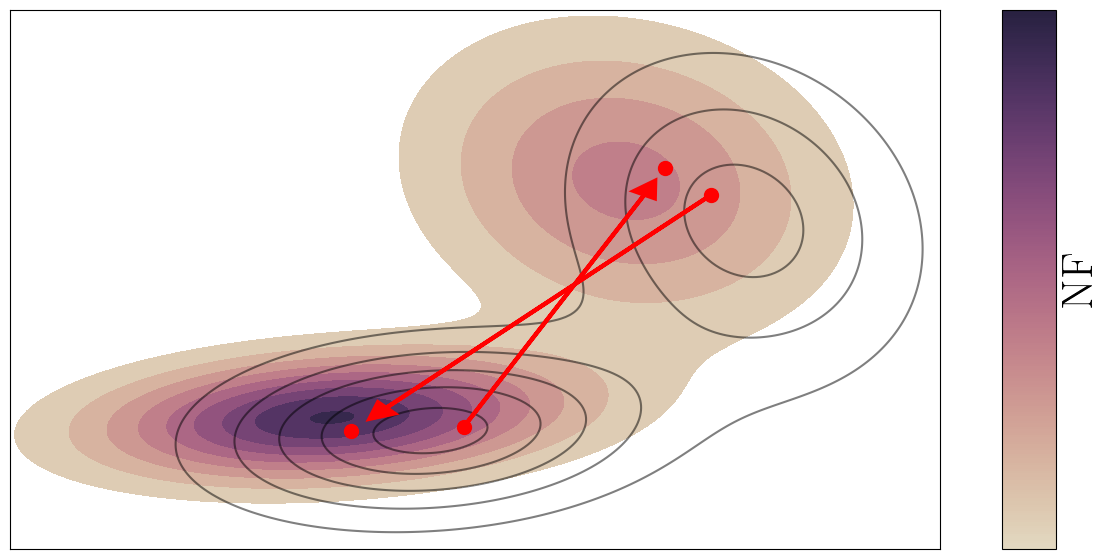

In [36]:
# # Get the samples
# np.random.seed(40)
# n_samples = n_walkers
# n_samples = 6
# # n_samples_keep = 20
# samples = sample_mixture_of_gaussians(mus_nf, Sigmas_nf, weights, size=n_samples)
# samples = np.array(samples)

# log_prob_samples = jax.vmap(get_walker_Z)(samples)
# sort_idx = np.argsort(log_prob_samples)[::-1]
# log_prob_samples = log_prob_samples[sort_idx]
# print(log_prob_samples)
# samples = samples[sort_idx]

# # Keep half of the list, with largest log prob
# keep_idx = sort_idx[:n_samples // 2]
# accepted_samples = samples[keep_idx]
# rejected_samples = samples[~keep_idx]



# Now two subplots, one for the original 2D projection and another for the NF 2D projection
fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot(111)
ax.contour(X, Y, Z, 
           linewidths = 1.5,
           alpha = 0.5, 
           levels = 5,
           colors = "black")
ax.contourf(X, Y, Z_nf, cmap=my_cmap_nf, locator = ticker.MaxNLocator(prune = 'lower'))
# ax.contourf(X, Y, Z, cmap=my_cmap, locator = ticker.MaxNLocator(prune = 'lower'), alpha = 0.5)

new_points = np.array([
    [ 2.0,  3.0],
    [-2.0, -2.0]])

# Trajectories:
for trajectory, new_point in zip(trajectory_list, new_points):
    first_point = trajectory[-1]
    last_point = new_point
    ax.scatter(first_point[0], first_point[1], color = walker_color, s=s_2D, marker = "o", zorder = 1e9)
    ax.scatter(last_point[0], last_point[1], color = walker_color, s=s_2D, marker = "o", zorder = 1e9)
    
    my_fraction = 0.95
    ax.arrow(first_point[0], first_point[1], 
             my_fraction * (last_point[0] - first_point[0]), 
             my_fraction * (last_point[1] - first_point[1]), 
             head_width=0.3, 
             head_length=0.3, 
             linewidth = 3,
             fc=walker_color, 
             ec=walker_color, 
             zorder = 1e10, 
             length_includes_head = True)


ax.grid(False)
ax.set_xlim(-6.35, 5.5)
ax.set_ylim(-4.25, 6)
ax.set_xticks([])
ax.set_yticks([])

# ### Walker(s)
# ax.plot(trajectory[:, 0], trajectory[:, 1], linewidth = lw_2D, color = "red")
# ax.scatter(trajectory[0, 0], trajectory[0, 1], color = "darkred", s=s_2D, marker = "o", zorder = 1e9)
# ax.scatter(rejected_samples[:, 0], rejected_samples[:, 1], linewidth = 2, marker = "x", color = "black", zorder = 1e9)
# ax.scatter(accepted_samples[:, 0], accepted_samples[:, 1], linewidth = lw_2D, marker = "o", color = "red", zorder = 1e9)

# ax.set_title("Global sampling", fontsize = title_fontsize)

norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=my_cmap_nf, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.2, aspect=10)

cbar.ax.set_yticks([])

cbar.set_label("NF", fontsize = label_fontsize)

# Adjust DPI
# plt.gcf().set_dpi(dpi_value)
# plt.gcf().set_facecolor('none')

# Save the plot as SVG
plt.savefig('mixture_of_gaussians_projection_with_NF.png', transparent=True, bbox_inches='tight')
plt.savefig('mixture_of_gaussians_projection_with_NF.svg', transparent=True, bbox_inches='tight', format='svg')
plt.show()

### As 3D plot

In [37]:
# fig = plt.figure(figsize=(12, 7))
# ax1 = fig.add_subplot(projection='3d', computed_zorder = False)
# # Meshgrid for the plot
# pos = np.empty(X.shape + (2,))
# pos[:, :, 0] = X
# pos[:, :, 1] = Y
# s = 7
# lw = 2.5

# elevation_shift = 0.0

# # Plot the mixture of Gaussians
# Z = mixture_of_gaussians(pos, mus, Sigmas, weights)
# Z_nf = mixture_of_gaussians(pos, mus_nf, Sigmas_nf, weights)

# alpha = 0.5

# ax1.plot_surface(X, Y, Z - elevation_shift, rstride=3, cstride=3, linewidth=1, antialiased=True,
#                 cmap=my_cmap, alpha=alpha, zorder = 1)
# ax1.plot_surface(X, Y, Z_nf - elevation_shift, rstride=3, cstride=3, linewidth=1, antialiased=True,
#                 cmap=my_cmap_nf, alpha=alpha, zorder = 1)

# # ### Plot the walker(s)
# # # ax1.scatter(trajectory[:, 0], trajectory[:, 1], walker_Z, color = "red", s=s, zorder = 1e8)
# # ax1.plot(trajectory[:, 0], trajectory[:, 1], walker_Z, color = "red", linewidth = lw, zorder = 1e8)
# # ax1.scatter(trajectory[0, 0], trajectory[0, 1], walker_Z[0], color = "darkred", s=s, marker = "o", zorder = 1e9)

# # rejected_Z = jax.vmap(get_walker_Z)(rejected_samples)
# # accepted_Z = jax.vmap(get_walker_Z)(accepted_samples)

# # ax1.scatter(rejected_samples[:, 0], rejected_samples[:, 1], rejected_Z, marker = "x", color = "white")
# # ax1.scatter(accepted_samples[:, 0], accepted_samples[:, 1], accepted_Z, marker = "o", color = "red")

# # Save the plot
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.set_zticks([])
# ax1.set_axis_off()
# plt.gcf().set_facecolor('none')
# plt.gcf().set_dpi(dpi_value)
# ax1.set_xlabel("x")
# ax1.set_ylabel("y")
# plt.savefig('mixture_of_gaussians_with_NF.svg', transparent=True, bbox_inches='tight', format='svg')
# plt.show()

## Colorbar plots

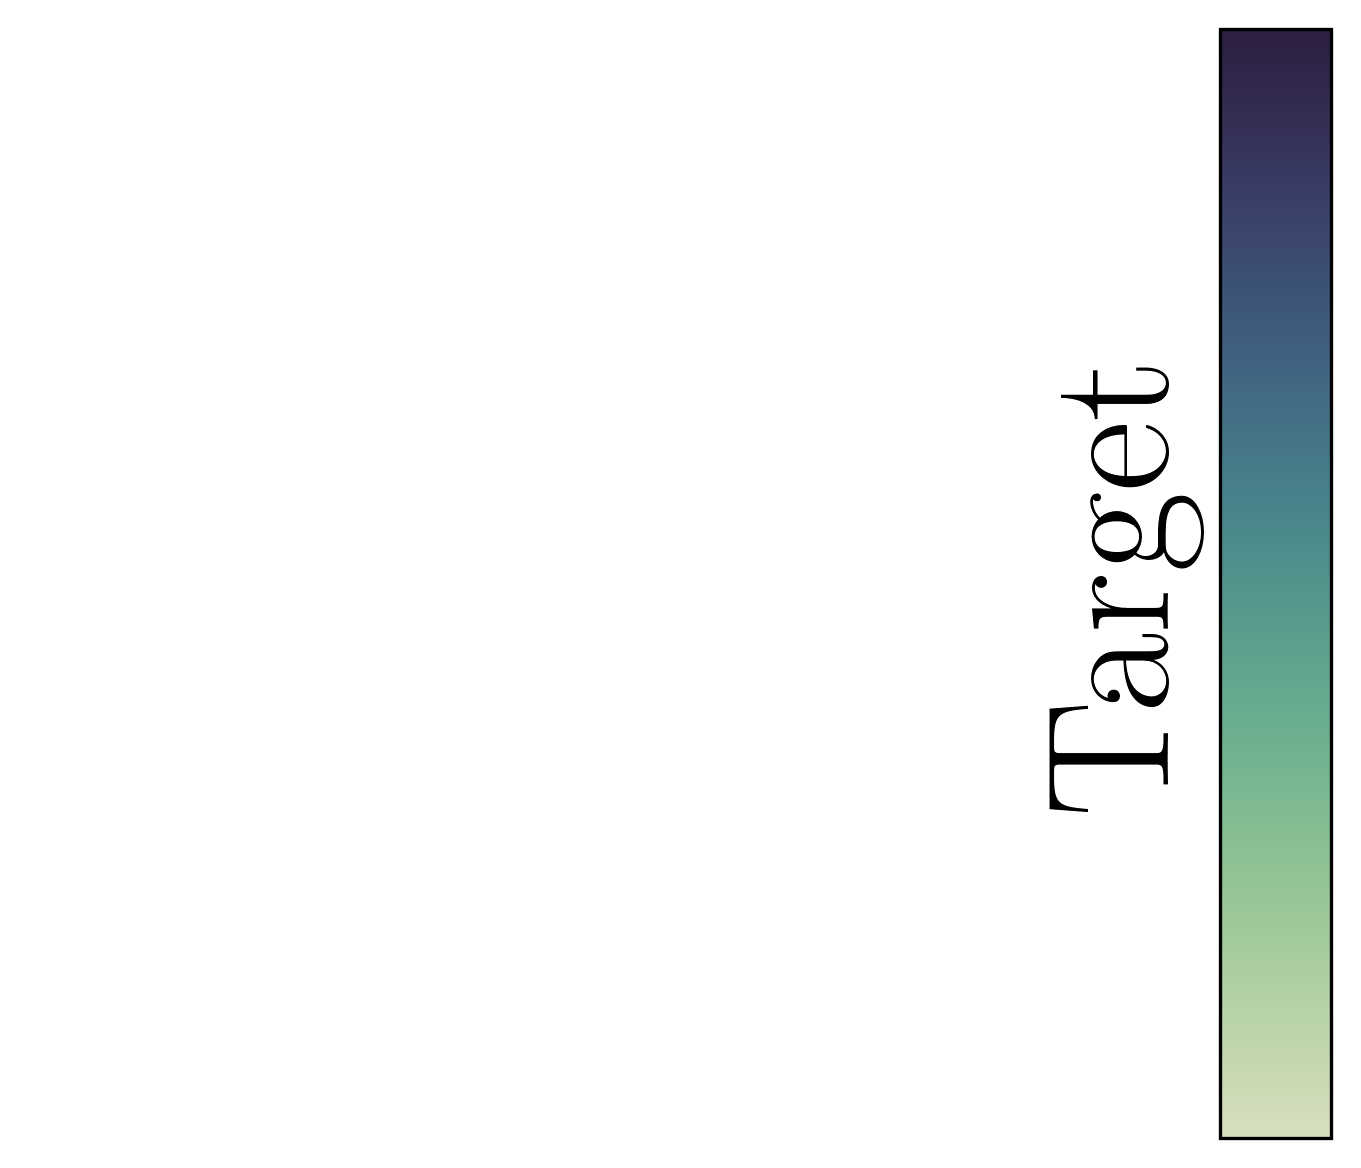

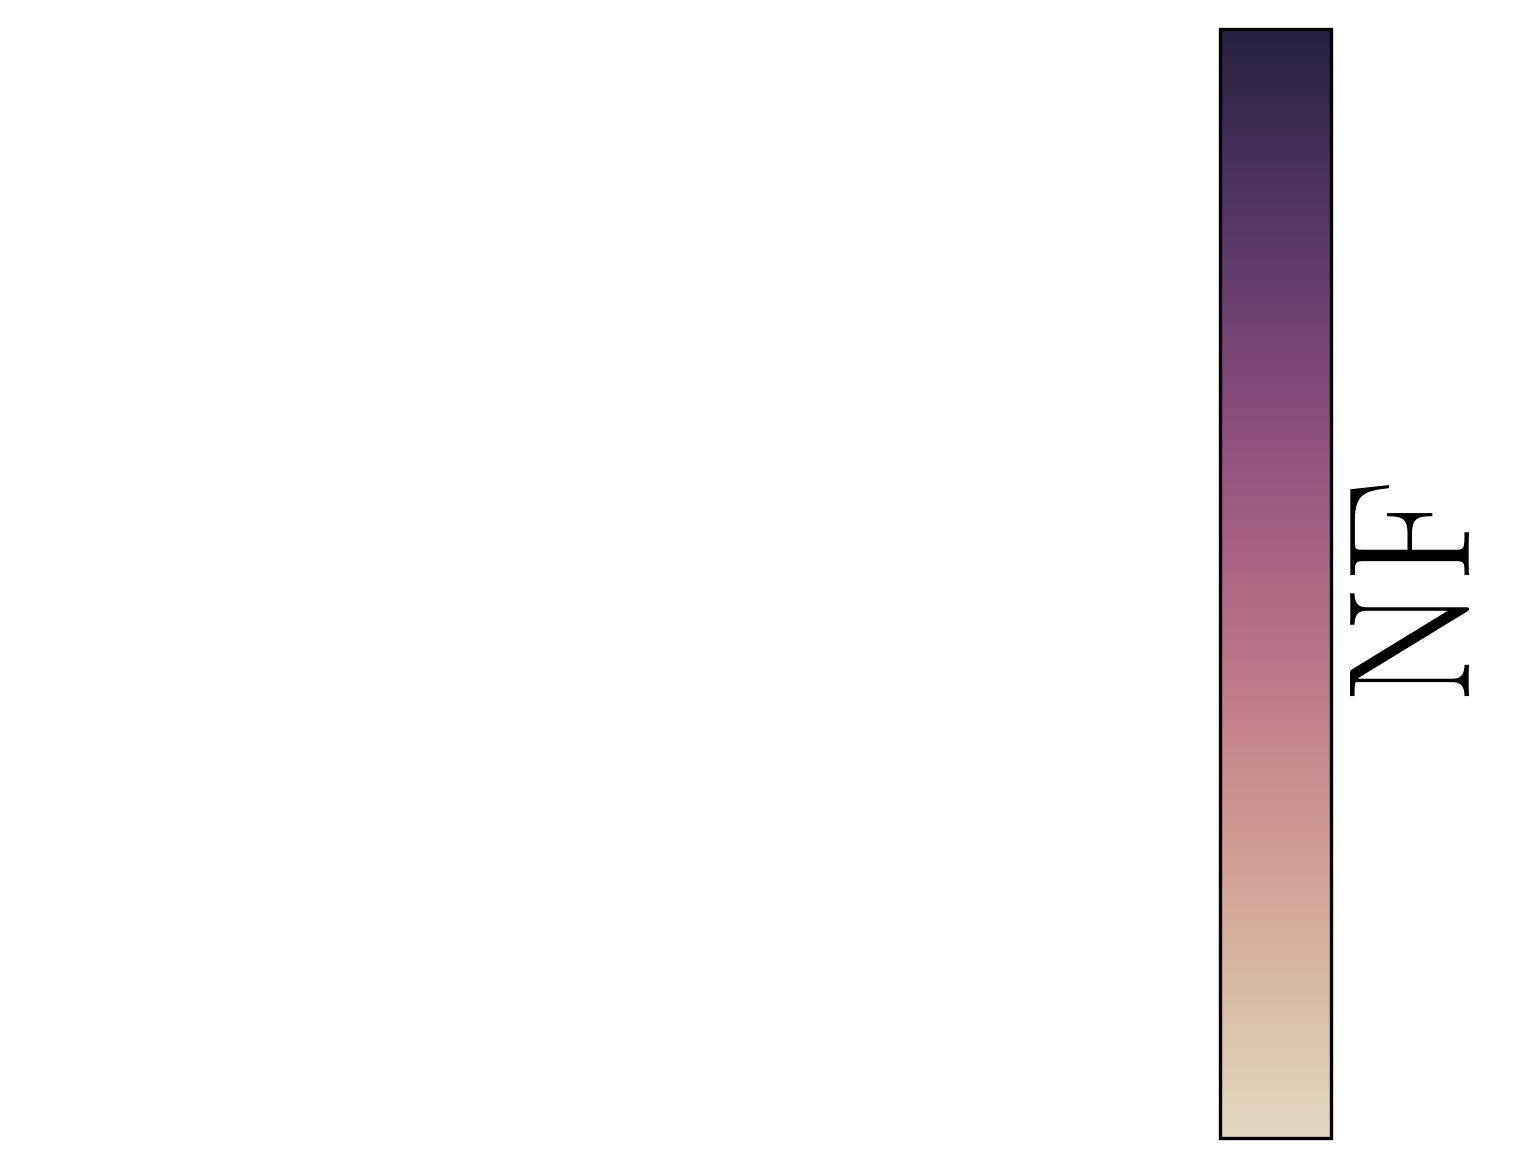

In [38]:

for cmap, save_name, label in zip([my_cmap, my_cmap_nf], ["cmap_target", "cmap_nf"], ["Target", "NF"]):
    fig, ax = plt.subplots()

    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.2, aspect=10)

    cbar.ax.set_yticks([])

    ax.set_axis_off()
    plt.gcf().set_facecolor('none')
    plt.gcf().set_dpi(dpi_value)
    
    # Add label to the colorbar
    
    label_fontsize = 42
    cbar.set_label(label)
    
    # Position the label
    if label == "Target":
        cbar.ax.yaxis.set_label_position('left')
        cbar.ax.yaxis.label.set_size(label_fontsize)
    else:
        cbar.ax.yaxis.set_label_position('right')
        cbar.ax.yaxis.label.set_size(label_fontsize)
    
    # Save the figure with tight bounding box
    plt.savefig(f'{save_name}.svg', bbox_inches='tight', format='svg')
    plt.show()

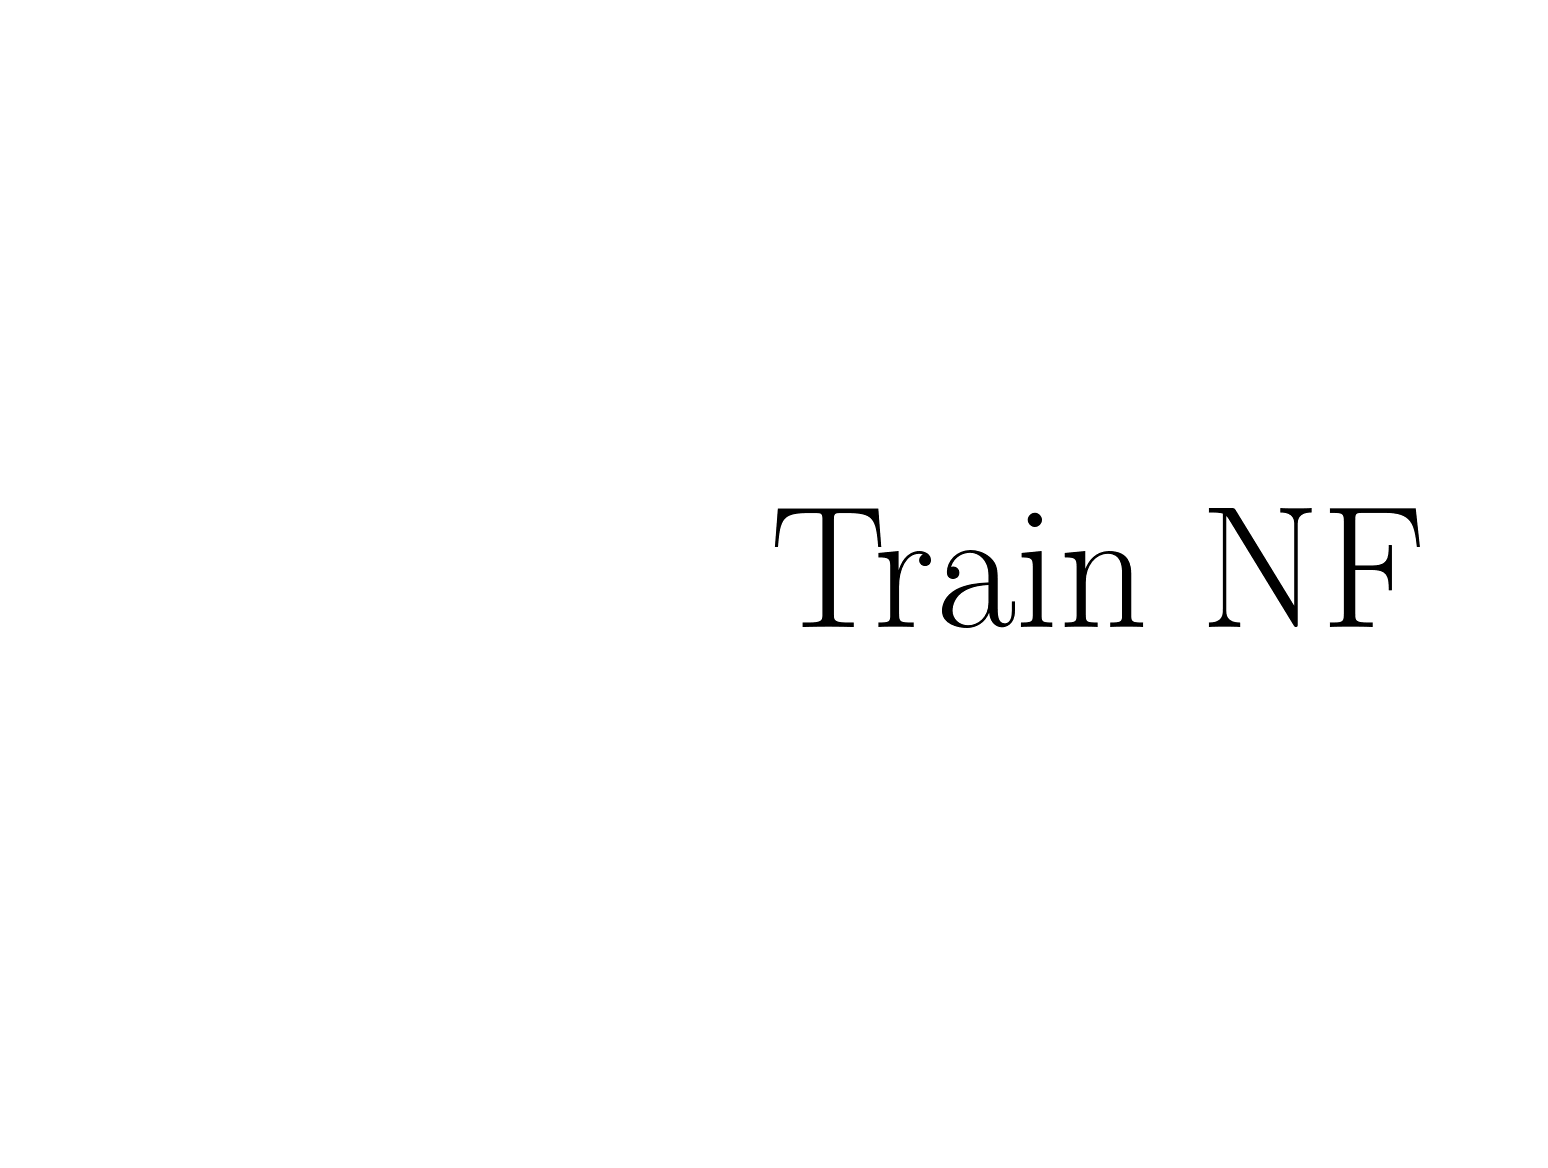

In [39]:

# fig, ax = plt.subplots()

# norm = plt.Normalize(vmin=0, vmax=1)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.2, aspect=10)

# cbar.ax.set_yticks([])

# ax.set_axis_off()
# plt.gcf().set_facecolor('none')
# plt.gcf().set_dpi(dpi_value)

# # Add label to the colorbar
# label_fontsize = 42
# cbar.set_label(r"\texttt{if training_loop:}")
# cbar.ax.yaxis.set_label_position('left')
# cbar.ax.yaxis.label.set_size(label_fontsize)

# # Save the figure with tight bounding box
# plt.savefig(f'if_training_loop.svg', bbox_inches='tight', format='svg')
# plt.show()


# Create a figure and axis without displaying it
fig, ax = plt.subplots()
ax.axis('off')  # Turn off the axis

# Add the text block
text = r"""Train NF"""
ax.text(0.5, 0.5, text, ha='left', va='center', fontsize=label_fontsize)

# Save the figure with tight bounding box
plt.gcf().set_facecolor('none')
plt.gcf().set_dpi(dpi_value)
plt.savefig(f'train_NF.svg', bbox_inches='tight', format='svg')
plt.show()

## Plot the 3D surface

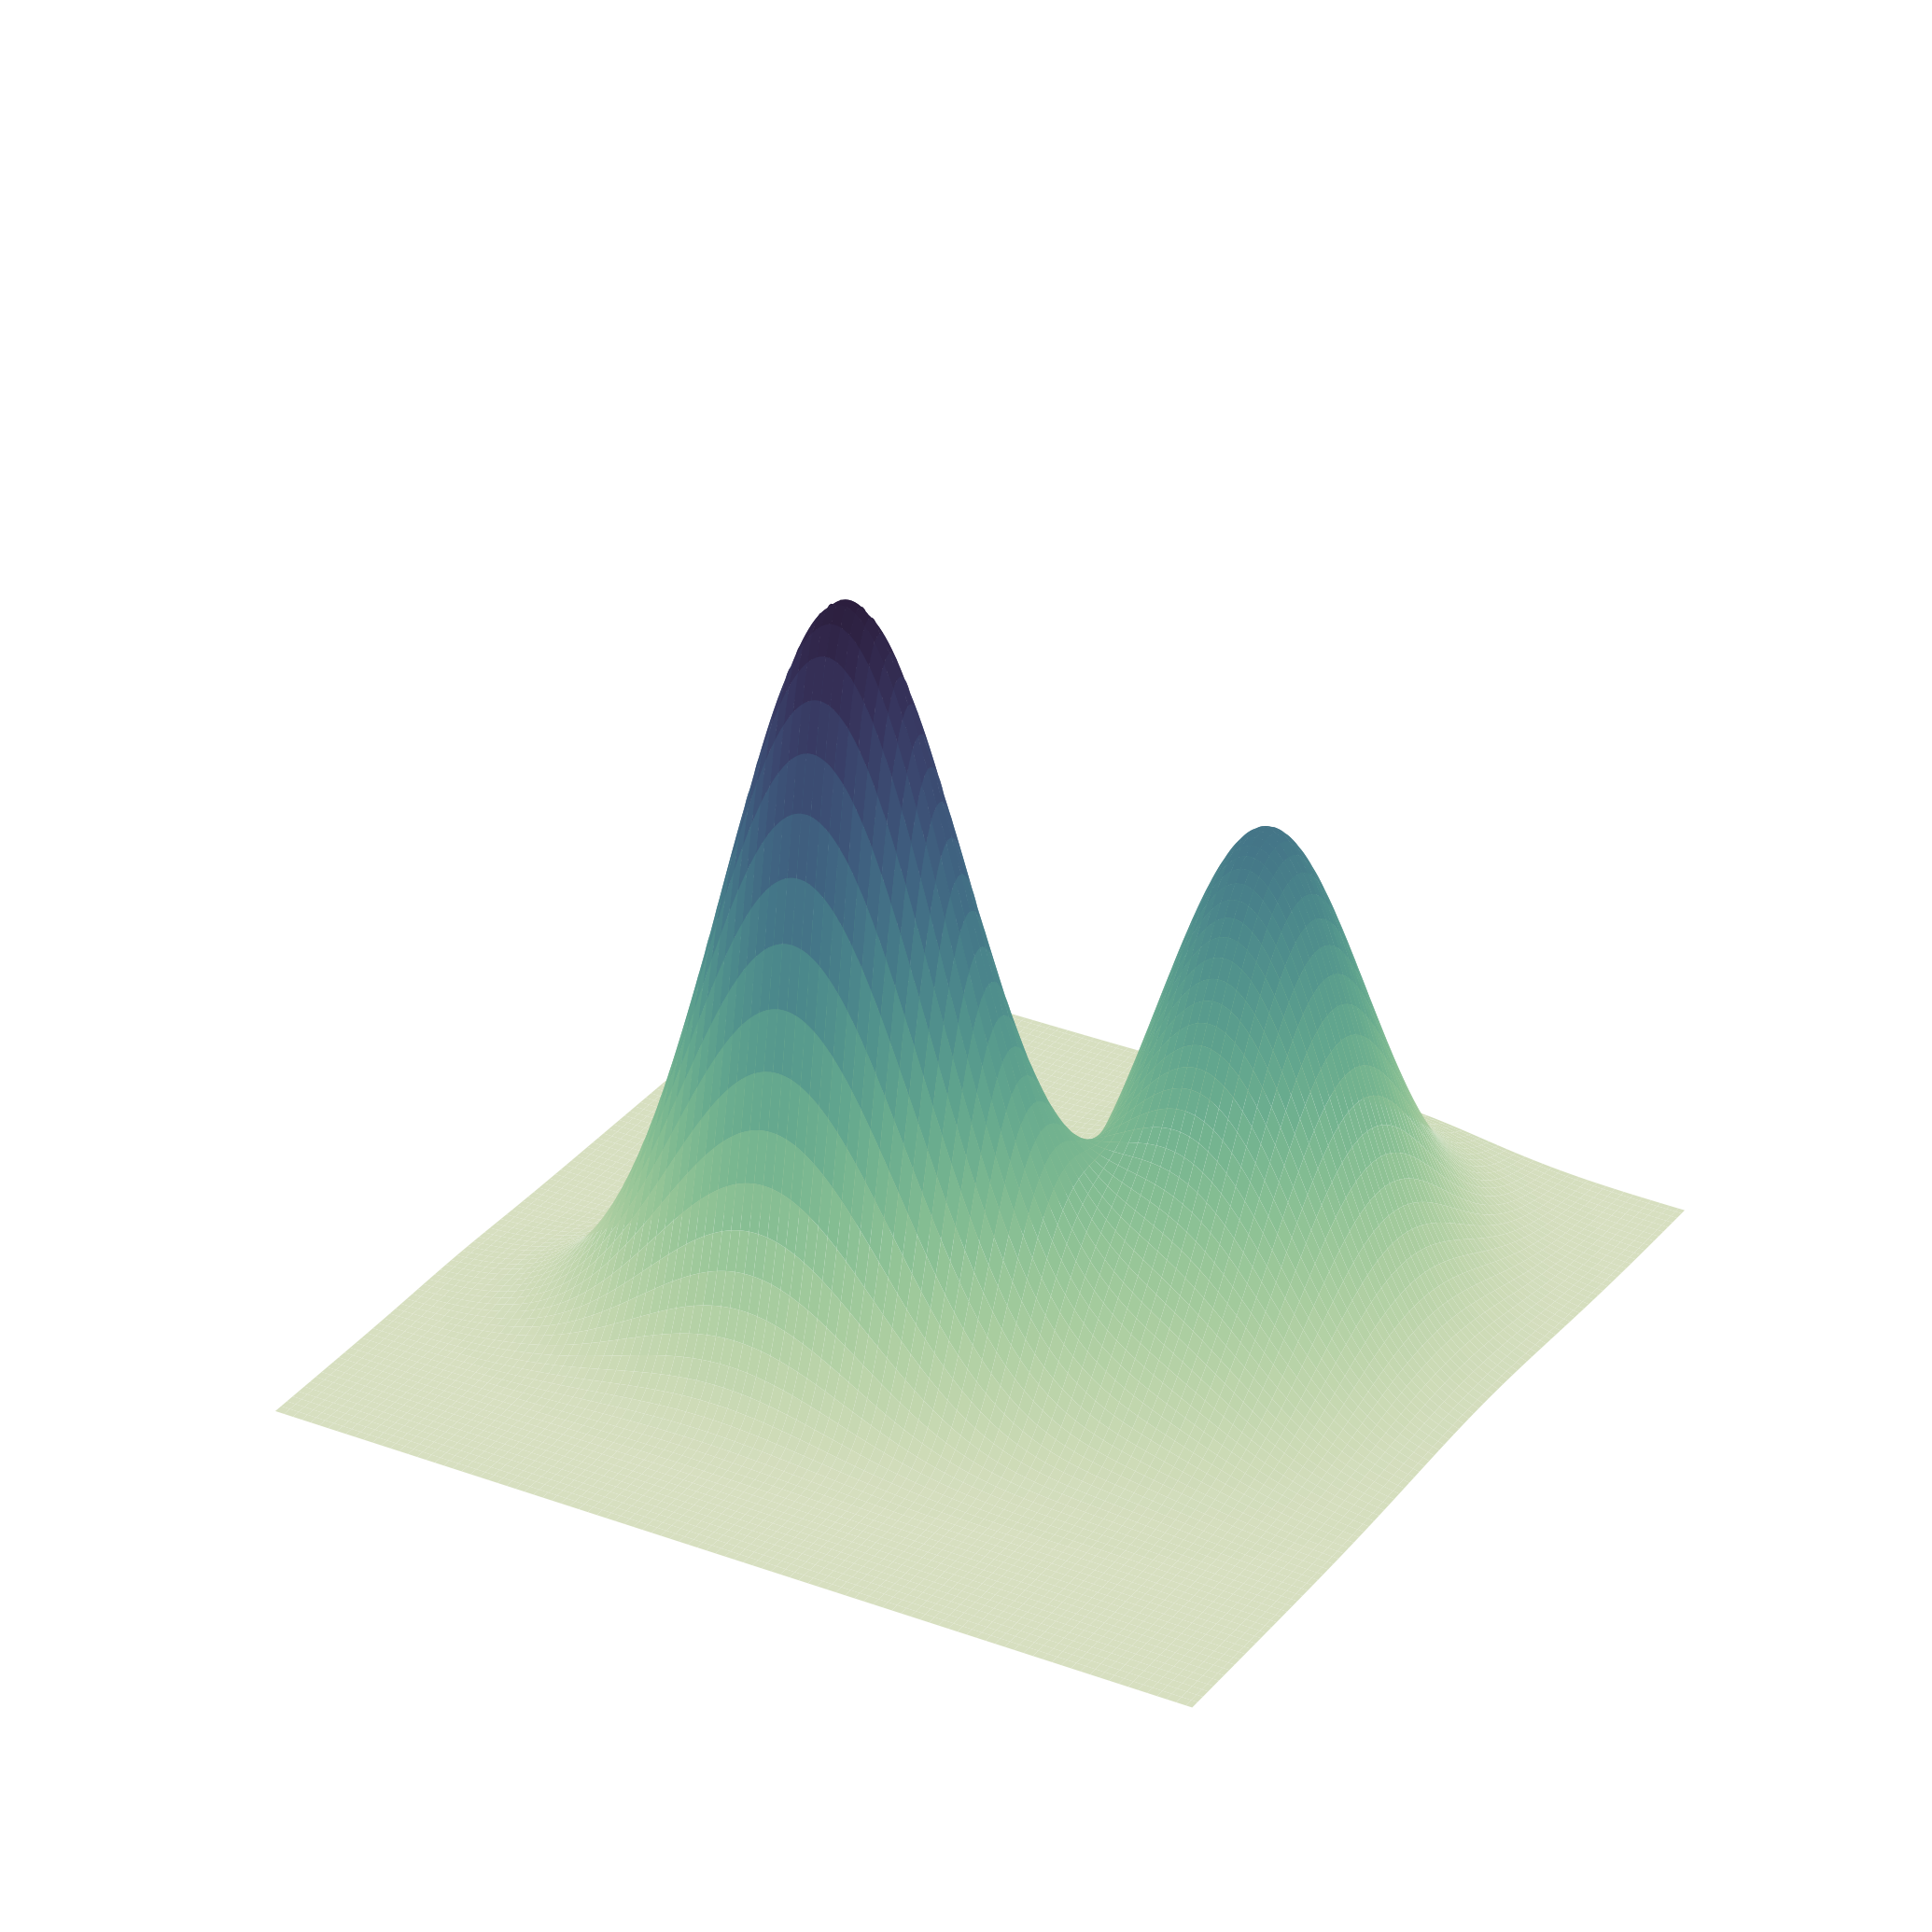

In [40]:
fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(projection='3d', computed_zorder = False)


surf = ax1.plot_surface(X, Y, Z - elevation_shift, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=my_cmap, alpha=1, zorder = 1)

# ### Plot the walker(s)
# ax1.plot(trajectory[:, 0], trajectory[:, 1], walker_Z, color = "red", linewidth = lw, zorder = 1e8)
# ax1.scatter(trajectory[0, 0], trajectory[0, 1], walker_Z[0], color = "darkred", s=s, marker = "o", zorder = 1e9)

# for trajectory, Z_values in zip(trajectory_list, walker_Z_list):
#     ax1.plot(trajectory[:, 0], trajectory[:, 1], Z_values, color = "red", linewidth = lw, zorder = 1e8)
#     ax1.scatter(trajectory[0, 0], trajectory[0, 1], Z_values[0], color = "darkred", s=s, marker = "o", zorder = 1e9)
#     break

# Save the plot
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_axis_off()
plt.gcf().set_facecolor('none')
plt.gcf().set_dpi(dpi_value)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
# Set the colorbar:
# cbar = fig.colorbar(surf, aspect=1)
# cbar.set_label('Target')
# cbar.set_ticks([])
# cbar.set_ticklabels([0, 0.1, 0.2, 0.3])
# cbar.set_alpha(1)
# cbar.draw_all()
plt.tight_layout()

plt.savefig('mixture_of_gaussians.svg', transparent=True, bbox_inches='tight', format='svg')
plt.show()